In [1]:
import torch
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import ast
from Bio import SeqIO
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/homebrew/anaconda3/envs/AIMA05/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/homebrew/anaconda3/envs/AIMA05/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/homebrew/anaconda3/envs/AIMA05/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/homebrew/anaconda3/envs/AIMA05/lib/python3.10/site-packages/traitlets/config/application.py", lin

# Data loading

In [2]:
def load_fasta_dataframe(file_path):
    """
    Load fasta file into a pandas dataframe
    :param file_path: path to fasta file
    :return: dataframe with columns 'id', 'sequence', 'seq_len'
    """
    # read fasta file
    records = [(record.id, str(record.seq)) for record in SeqIO.parse(file_path, "fasta")]

    # create dataframe
    df_fasta = pd.DataFrame(records, columns=['id', 'sequence'])
    df_fasta["seq_len"] = df_fasta["sequence"].apply(len)
    return df_fasta

def load_binding_sites_dataframe(file_path, target=None):
    """
    Load binding sites file into a pandas dataframe
    :param file_path: path to binding sites file
    :param target: target protein class ('metal', 'nuclear', 'small')
    :return: dataframe with columns 'id', 'binding_sites'
    """
    # check if target is valid
    assert target in ['metal', 'nuclear', 'small'], "target must be one of 'metal', 'nuclear', 'small'"

    # read binding sites file
    binding_sites = []
    with open(file_path, 'r') as f:
        for line in f:
            protein_id, sites = line.strip().split('\t')
            binding_sites.append((protein_id, [int(site) for site in sites.split(',')]))

    # create dataframe
    df_binding_sites = pd.DataFrame(binding_sites, columns=['id', 'binding_sites'])
    df_binding_sites["num_residues"] = df_binding_sites["binding_sites"].apply(len)
    df_binding_sites["target"] = target
    return df_binding_sites

In [3]:
df_proteins = load_fasta_dataframe("raw_data/development_set/all.fasta")
display(df_proteins.head())

,id,sequence,seq_len
0,Q5LL55,MSETWLPTLVTATPQEGFDLAVKLSRIAVKKTQPDAQVRDTLRAVY...,76
1,H9L4N9,MQINIQGHHIDLTDSMQDYVHSKFDKLERFFDHINHVQVILRVEKL...,95
2,O34738,MKSWKVKEIVIMSVISIVFAVVYLLFTHFGNVLAGMFGPIAYEPIY...,199
3,P39579,MDFKQEVLDVLAEVCQDDIVKENPDIEIFEEGLLDSFGTVELLLAI...,78
4,P01887,MARSVTLVFLVLVSLTGLYAIQKTPQIQVYSRHPPENGKPNILNCY...,119


count    1314.000000
mean      177.606545
std        86.386191
min        31.000000
25%       121.000000
50%       160.500000
75%       220.000000
max       813.000000
Name: seq_len, dtype: float64


array([[<Axes: title={'center': 'seq_len'}>]], dtype=object)

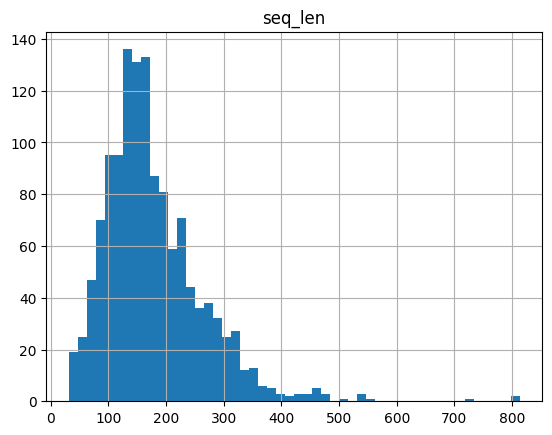

In [4]:
print(df_proteins["seq_len"].describe())
df_proteins.hist(column='seq_len', bins=50)

In [5]:
df_metal_sites = load_binding_sites_dataframe("raw_data/development_set/binding_residues_2.5_metal.txt", target='metal')
df_nuclear_sites = load_binding_sites_dataframe("raw_data/development_set/binding_residues_2.5_nuclear.txt", target='nuclear')
df_small_sites = load_binding_sites_dataframe("raw_data/development_set/binding_residues_2.5_small.txt", target='small')

# EDA

In [6]:
def eda_binding_sites(df):
    """
    Perform exploratory data analysis on binding sites dataframe
    :param df: binding sites dataframe
    """
    # print first few rows
    display(df.head())
    
    # create column sites_pos_stats to describe statistics of 'num_residues'
    df["sites_pos_min"] = df["binding_sites"].apply(min)
    df["sites_pos_max"] = df["binding_sites"].apply(max)
    df["sites_pos_mean"] = df["binding_sites"].apply(lambda x: sum(x) / len(x))
    df["sites_pos_std"] = df["binding_sites"].apply(lambda x: (sum([(pos - sum(x) / len(x))**2 for pos in x]) / len(x))**0.5)
    df["sites_pos_median"] = df["binding_sites"].apply(lambda x: sorted(x)[len(x) // 2])

    # print statistics of 'sites_pos_*'
    print("Statistics of 'sites_pos_*'")
    print("\nMin description")
    print(df["sites_pos_min"].describe())

    print("\nMax description")
    print(df["sites_pos_max"].describe())

    print("\nMean description")
    print(df["sites_pos_mean"].describe())

    print("\nMedian description")
    print(df["sites_pos_median"].describe())


    # plot histogram of 'num_residues'
    df.hist(column='num_residues', bins=50)

    # plot density of 'sites_pos_*' overlap each other (alpha=0.5), xlim=(0, 1000)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.kdeplot(df["sites_pos_min"], color='blue', label='min', ax=ax)
    sns.kdeplot(df["sites_pos_max"], color='red', label='max', ax=ax)
    sns.kdeplot(df["sites_pos_mean"], color='green', label='mean', ax=ax)
    sns.kdeplot(df["sites_pos_std"], color='orange', label='std', ax=ax)
    sns.kdeplot(df["sites_pos_median"], color='purple', label='median', ax=ax)
    ax.set_xlim(0, 1000)
    plt.title("Density of 'sites_pos_*'")
    plt.legend()
    plt.show()

## Metal sites

,id,binding_sites,num_residues,target
0,P02185,"[37, 30, 36, 39, 120, 69, 63, 42, 44, 25, 123,...",14,metal
1,P09211,"[30, 8, 31, 86, 14, 148, 117, 118, 82, 78, 114]",11,metal
2,P00817,"[153, 121, 57, 79, 193, 116, 155, 102, 148, 11...",12,metal
3,P01112,"[76, 30, 28, 165, 73, 35, 61, 138, 16, 3, 33, ...",27,metal
4,P07378,"[399, 377, 376, 219, 39]",5,metal


Statistics of 'sites_pos_*'

Min description
count    6836.000000
mean      178.074605
std       295.381779
min         1.000000
25%        41.000000
50%        98.000000
75%       202.000000
max      5477.000000
Name: sites_pos_min, dtype: float64

Max description
count     6836.000000
mean       315.752048
std        526.939767
min          2.000000
25%        143.000000
50%        234.000000
75%        360.000000
max      33364.000000
Name: sites_pos_max, dtype: float64

Mean description
count    6836.000000
mean      244.135288
std       323.558302
min         2.000000
25%        97.973684
50%       166.572727
75%       274.616667
max      7958.875000
Name: sites_pos_mean, dtype: float64

Median description
count    6836.000000
mean      251.158133
std       318.454752
min         2.000000
25%        97.000000
50%       174.000000
75%       288.000000
max      5527.000000
Name: sites_pos_median, dtype: float64


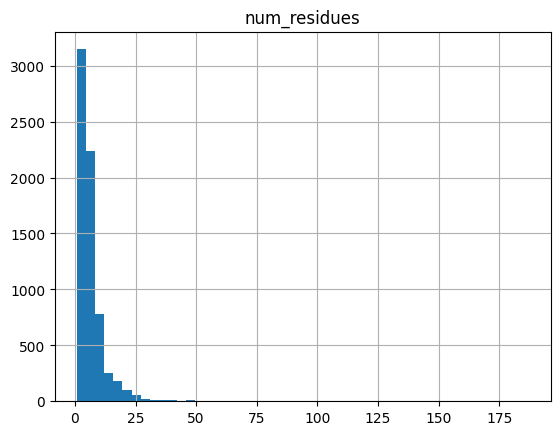

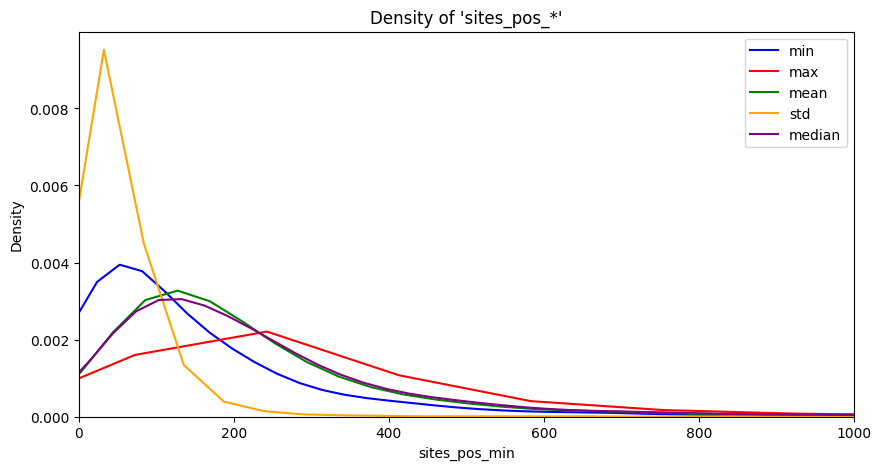

In [7]:
eda_binding_sites(df_metal_sites)

## Nuclear sites

,id,binding_sites,num_residues,target
0,P00698,"[28, 19, 144, 24, 25, 23, 146, 145]",8,nuclear
1,P08046,"[379, 350, 377, 375, 418, 380, 334, 359, 406, ...",40,nuclear
2,P27958,"[1418, 1295, 1324, 1397, 1527, 1298, 1439, 125...",22,nuclear
3,P06401,"[576, 637, 616, 617, 636, 638, 588, 592, 635, ...",17,nuclear
4,P00648,"[104, 84, 150, 82, 85, 106, 103, 134, 131, 149...",17,nuclear


Statistics of 'sites_pos_*'

Min description
count     934.000000
mean      155.791221
std       259.576649
min         1.000000
25%        17.000000
50%        55.000000
75%       189.500000
max      2456.000000
Name: sites_pos_min, dtype: float64

Max description
count     934.000000
mean      337.544968
std       330.786843
min        22.000000
25%       131.250000
50%       240.500000
75%       423.000000
max      2995.000000
Name: sites_pos_max, dtype: float64

Mean description
count     934.000000
mean      246.790754
std       285.804376
min        12.454545
25%        78.928571
50%       162.629808
75%       307.083333
max      2721.500000
Name: sites_pos_mean, dtype: float64

Median description
count     934.000000
mean      248.915418
std       290.664542
min         9.000000
25%        77.000000
50%       156.000000
75%       313.750000
max      2730.000000
Name: sites_pos_median, dtype: float64


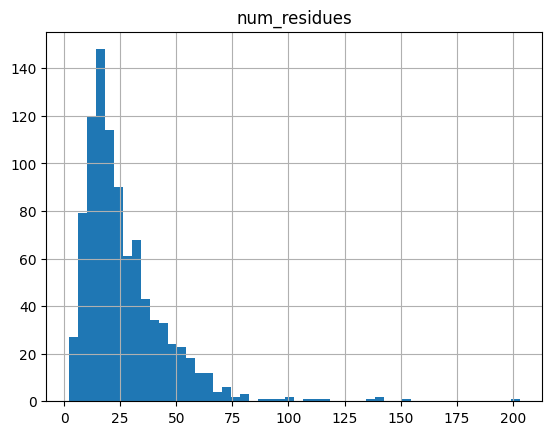

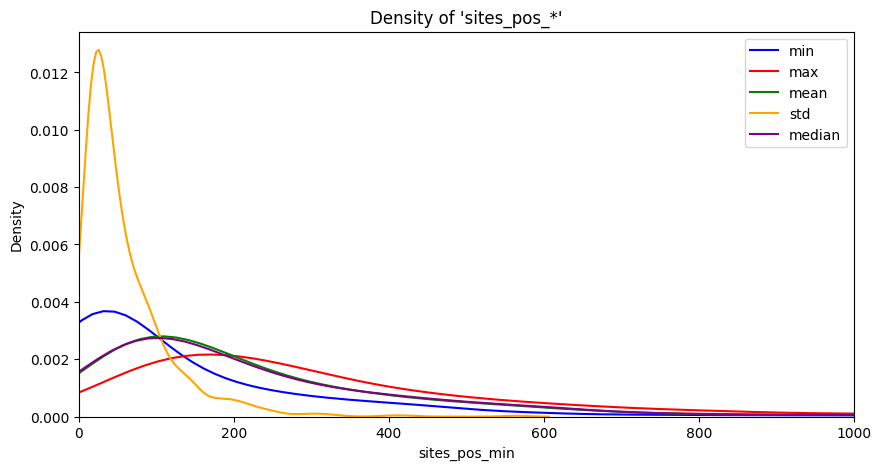

In [8]:
eda_binding_sites(df_nuclear_sites)

## Small sites

,id,binding_sites,num_residues,target
0,P02185,"[46, 73, 69, 35, 138, 111, 44, 109, 25, 90, 10...",68,small
1,P09211,"[14, 110, 52, 35, 109, 206, 45, 58, 103, 106, ...",46,small
2,P00817,"[121, 209, 199, 194, 228, 118, 224, 153, 57, 7...",20,small
3,P00963,"[310, 100, 46, 219, 72, 218, 110, 77, 111, 118...",25,small
4,P01112,"[14, 35, 42, 61, 111, 44, 109, 25, 150, 60, 10...",70,small


Statistics of 'sites_pos_*'

Min description
count    11283.000000
mean       120.937517
std        404.843110
min          1.000000
25%         20.000000
50%         46.000000
75%        105.000000
max      31968.000000
Name: sites_pos_min, dtype: float64

Max description
count    11283.000000
mean       331.998316
std        435.253274
min          3.000000
25%        170.000000
50%        266.000000
75%        388.000000
max      32020.000000
Name: sites_pos_max, dtype: float64

Mean description
count    11283.000000
mean       223.421992
std        414.209903
min          2.500000
25%         98.133929
50%        157.869565
75%        239.166667
max      32002.333333
Name: sites_pos_mean, dtype: float64

Median description
count    11283.000000
mean       226.547727
std        417.680666
min          3.000000
25%         95.000000
50%        159.000000
75%        247.000000
max      32019.000000
Name: sites_pos_median, dtype: float64


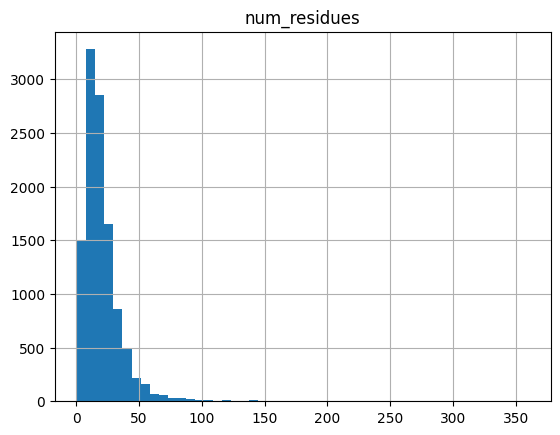

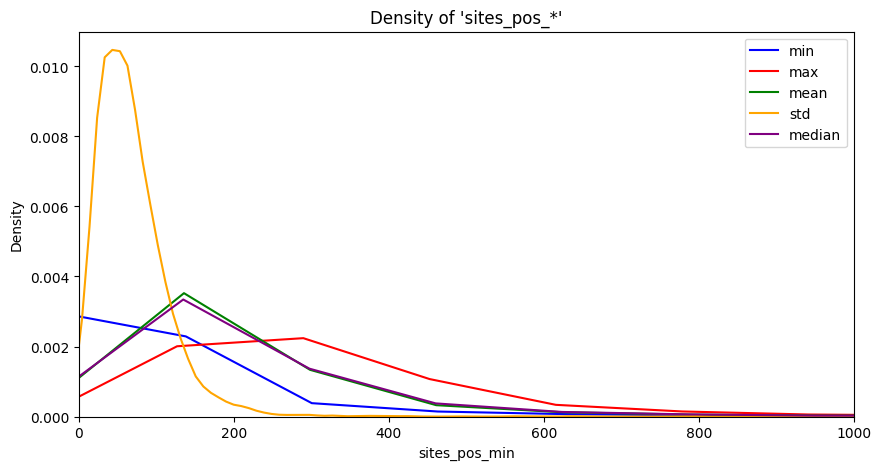

In [9]:
eda_binding_sites(df_small_sites)

# Combine all fasta

In [10]:
# combine all dataframes sites
df_all_sites = pd.concat([df_metal_sites, df_nuclear_sites, df_small_sites], ignore_index=True)
display(df_all_sites.head())

,id,binding_sites,num_residues,target,sites_pos_min,sites_pos_max,sites_pos_mean,sites_pos_std,sites_pos_median
0,P02185,"[37, 30, 36, 39, 120, 69, 63, 42, 44, 25, 123,...",14,metal,13,123,54.714286,31.342414,44
1,P09211,"[30, 8, 31, 86, 14, 148, 117, 118, 82, 78, 114]",11,metal,8,148,75.090909,45.540101,82
2,P00817,"[153, 121, 57, 79, 193, 116, 155, 102, 148, 11...",12,metal,57,193,116.250000,39.423185,118
3,P01112,"[76, 30, 28, 165, 73, 35, 61, 138, 16, 3, 33, ...",27,metal,3,166,80.259259,52.918241,73
4,P07378,"[399, 377, 376, 219, 39]",5,metal,39,399,282.000000,137.526725,376


In [11]:
df_all_sites["target"].value_counts()

target
small      11283
metal       6836
nuclear      934
Name: count, dtype: int64

In [12]:
df_all_sites["target"].value_counts(normalize=True)

target
small      0.592190
metal      0.358789
nuclear    0.049021
Name: proportion, dtype: float64

In [13]:
# check sequence appear in different target
df_all_sites["id"].value_counts().value_counts().to_frame().sort_index()

,count
count,
1,10908
2,3804
3,179


In [14]:
# check percentage of sequence appear in different target
df_all_sites["id"].value_counts().value_counts(normalize=True).to_frame().sort_index()

,proportion
count,
1,0.732523
2,0.255456
3,0.012021


In [15]:
# drop duplicate sequences
print("Before drop duplicates")
print(df_all_sites["target"].value_counts())

df_all_sites_dedup = df_all_sites.drop_duplicates(subset='id')
print("\nAfter drop duplicates")
df_all_sites_dedup["target"].value_counts()

Before drop duplicates
target
small      11283
metal       6836
nuclear      934
Name: count, dtype: int64

After drop duplicates


target
small      7509
metal      6836
nuclear     546
Name: count, dtype: int64

In [16]:
# merge with df_proteins
print("Before merge")
print(df_proteins.shape)


df_all = pd.merge(df_proteins, df_all_sites, on='id', how='inner')
print("\nAfter merge")
print(df_all.shape)
display(df_all.head())

Before merge
(1314, 3)

After merge
(1579, 11)


,id,sequence,seq_len,binding_sites,num_residues,target,sites_pos_min,sites_pos_max,sites_pos_mean,sites_pos_std,sites_pos_median
0,Q5LL55,MSETWLPTLVTATPQEGFDLAVKLSRIAVKKTQPDAQVRDTLRAVY...,76,"[53, 46, 32, 42, 25, 60, 56, 43, 57, 31, 54, 2...",17,small,22,60,40.529412,11.887302,40
1,H9L4N9,MQINIQGHHIDLTDSMQDYVHSKFDKLERFFDHINHVQVILRVEKL...,95,"[51, 62, 42, 60, 55, 64]",6,metal,42,64,55.666667,7.498148,60
2,O34738,MKSWKVKEIVIMSVISIVFAVVYLLFTHFGNVLAGMFGPIAYEPIY...,199,"[100, 46, 104, 88, 63, 42, 77, 135, 91, 108, 2...",22,small,23,135,86.227273,34.010602,95
3,P39579,MDFKQEVLDVLAEVCQDDIVKENPDIEIFEEGLLDSFGTVELLLAI...,78,"[37, 36, 40, 61]",4,small,36,61,43.500000,10.210289,40
4,P01887,MARSVTLVFLVLVSLTGLYAIQKTPQIQVYSRHPPENGKPNILNCY...,119,"[83, 77]",2,metal,77,83,80.000000,3.000000,83


In [17]:
# create column is_duplicate to indicate if sequence is duplicate
df_all["is_duplicate"] = df_all["id"].duplicated(keep=False)
df_all["is_duplicate"].value_counts()

is_duplicate
False    1068
True      511
Name: count, dtype: int64

In [18]:
df_all.query("is_duplicate == True").head()

,id,sequence,seq_len,binding_sites,num_residues,target,sites_pos_min,sites_pos_max,sites_pos_mean,sites_pos_std,sites_pos_median,is_duplicate
4,P01887,MARSVTLVFLVLVSLTGLYAIQKTPQIQVYSRHPPENGKPNILNCY...,119,"[83, 77]",2,metal,77,83,80.000000,3.000000,83,True
5,P01887,MARSVTLVFLVLVSLTGLYAIQKTPQIQVYSRHPPENGKPNILNCY...,119,"[30, 117, 118, 116]",4,small,30,118,95.250000,37.678741,117,True
14,Q9KQN0,MTDVMFKSQIANQLKNLRKSRGLSLDATAQLTGVSKAMLGQIERGE...,181,"[120, 162, 126, 160]",4,metal,120,162,142.000000,19.131126,160,True
15,Q9KQN0,MTDVMFKSQIANQLKNLRKSRGLSLDATAQLTGVSKAMLGQIERGE...,181,"[51, 120, 105, 160, 107, 117, 173, 162, 90, 55...",11,small,51,173,115.090909,38.415088,117,True
22,Q05097,MAWKGEVLANNEAGQVTSIIYNPGDVITIVAAGWASYGPTQKWGPQ...,122,"[37, 105, 109, 108, 101]",5,metal,37,109,92.000000,27.640550,105,True


In [19]:
# save all data as parquet
df_all.to_csv("data_preparation/all_proteins.tsv", sep="|", index=False)
df_all.to_parquet("data_preparation/all_proteins.parquet", index=False)

## Assign to each fold

In [20]:
df_all = pd.read_parquet("data_preparation/all_proteins.parquet")
print(df_all.shape)
display(df_all.head())

(1579, 12)


,id,sequence,seq_len,binding_sites,num_residues,target,sites_pos_min,sites_pos_max,sites_pos_mean,sites_pos_std,sites_pos_median,is_duplicate
0,Q5LL55,MSETWLPTLVTATPQEGFDLAVKLSRIAVKKTQPDAQVRDTLRAVY...,76,"[53, 46, 32, 42, 25, 60, 56, 43, 57, 31, 54, 2...",17,small,22,60,40.529412,11.887302,40,False
1,H9L4N9,MQINIQGHHIDLTDSMQDYVHSKFDKLERFFDHINHVQVILRVEKL...,95,"[51, 62, 42, 60, 55, 64]",6,metal,42,64,55.666667,7.498148,60,False
2,O34738,MKSWKVKEIVIMSVISIVFAVVYLLFTHFGNVLAGMFGPIAYEPIY...,199,"[100, 46, 104, 88, 63, 42, 77, 135, 91, 108, 2...",22,small,23,135,86.227273,34.010602,95,False
3,P39579,MDFKQEVLDVLAEVCQDDIVKENPDIEIFEEGLLDSFGTVELLLAI...,78,"[37, 36, 40, 61]",4,small,36,61,43.500000,10.210289,40,False
4,P01887,MARSVTLVFLVLVSLTGLYAIQKTPQIQVYSRHPPENGKPNILNCY...,119,"[83, 77]",2,metal,77,83,80.000000,3.000000,83,True


In [21]:
# Load fold splits
folds = []
for i in range(1, 6):
    with open(f"raw_data/development_set/ids_split{i}.txt", 'r') as f:
        folds.append((i, [line.strip() for line in f]))

# print first few lines of each fold
first_fold = folds[0]
print(first_fold[0], first_fold[1][:5])

# print data size of each fold
for fold in folds:
    print(f"Fold: {fold[0]}", len(fold[1]))

# print total data size
total_data_size = sum([len(fold[1]) for fold in folds])
print("Total data size:", total_data_size)

1 ['Q5LL55', 'H9L4N9', 'O34738', 'P39579', 'P01887']
Fold: 1 203
Fold: 2 203
Fold: 3 203
Fold: 4 203
Fold: 5 202
Total data size: 1014


In [22]:
# create columns fold to indicate which fold the sequence belongs to
df_all["fold"] = -1
for i, fold in folds:
    df_all.loc[df_all["id"].isin(fold), "fold"] = i

# check if all sequences are assigned to a fold
df_all["fold"].value_counts().sort_index()

fold
-1    410
 1    234
 2    229
 3    232
 4    236
 5    238
Name: count, dtype: int64

In [23]:
# check duplicate sequences in each fold
df_all.query("is_duplicate == True")["fold"].value_counts().sort_index()

fold
-1    204
 1     62
 2     52
 3     57
 4     65
 5     71
Name: count, dtype: int64

,id,sequence,seq_len,binding_sites,num_residues,target,sites_pos_min,sites_pos_max,sites_pos_mean,sites_pos_std,sites_pos_median,is_duplicate,fold
0,Q5LL55,MSETWLPTLVTATPQEGFDLAVKLSRIAVKKTQPDAQVRDTLRAVY...,76,"[53, 46, 32, 42, 25, 60, 56, 43, 57, 31, 54, 2...",17,small,22,60,40.529412,11.887302,40,False,1
1,H9L4N9,MQINIQGHHIDLTDSMQDYVHSKFDKLERFFDHINHVQVILRVEKL...,95,"[51, 62, 42, 60, 55, 64]",6,metal,42,64,55.666667,7.498148,60,False,1
2,O34738,MKSWKVKEIVIMSVISIVFAVVYLLFTHFGNVLAGMFGPIAYEPIY...,199,"[100, 46, 104, 88, 63, 42, 77, 135, 91, 108, 2...",22,small,23,135,86.227273,34.010602,95,False,1
3,P39579,MDFKQEVLDVLAEVCQDDIVKENPDIEIFEEGLLDSFGTVELLLAI...,78,"[37, 36, 40, 61]",4,small,36,61,43.500000,10.210289,40,False,1
4,P01887,MARSVTLVFLVLVSLTGLYAIQKTPQIQVYSRHPPENGKPNILNCY...,119,"[83, 77]",2,metal,77,83,80.000000,3.000000,83,True,1


Statistics of 'sites_pos_*'

Min description
count    1169.000000
mean       48.430282
std        46.061682
min         1.000000
25%        16.000000
50%        34.000000
75%        67.000000
max       356.000000
Name: sites_pos_min, dtype: float64

Max description
count    1169.000000
mean      128.891360
std        67.265404
min         3.000000
25%        82.000000
50%       122.000000
75%       163.000000
max       459.000000
Name: sites_pos_max, dtype: float64

Mean description
count    1169.000000
mean       88.091293
std        49.780911
min         2.500000
25%        53.583333
50%        79.666667
75%       111.368421
max       376.875000
Name: sites_pos_mean, dtype: float64

Median description
count    1169.000000
mean       90.398631
std        52.978901
min         3.000000
25%        53.000000
50%        81.000000
75%       116.000000
max       380.000000
Name: sites_pos_median, dtype: float64


/var/folders/y2/hzjfncr92llg100m08nwxmhc0000gn/T/ipykernel_74592/2942742068.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sites_pos_min"] = df["binding_sites"].apply(min)
/var/folders/y2/hzjfncr92llg100m08nwxmhc0000gn/T/ipykernel_74592/2942742068.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sites_pos_max"] = df["binding_sites"].apply(max)
/var/folders/y2/hzjfncr92llg100m08nwxmhc0000gn/T/ipykernel_74592/2942742068.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of

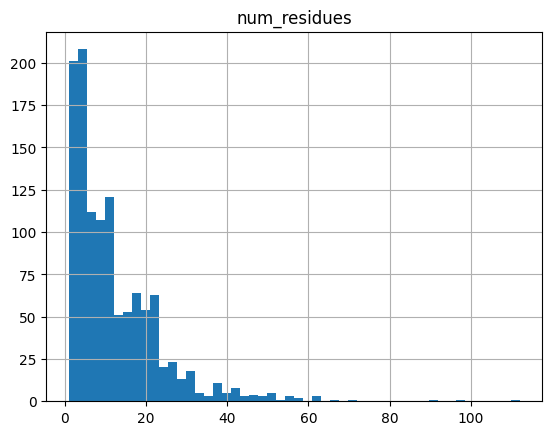

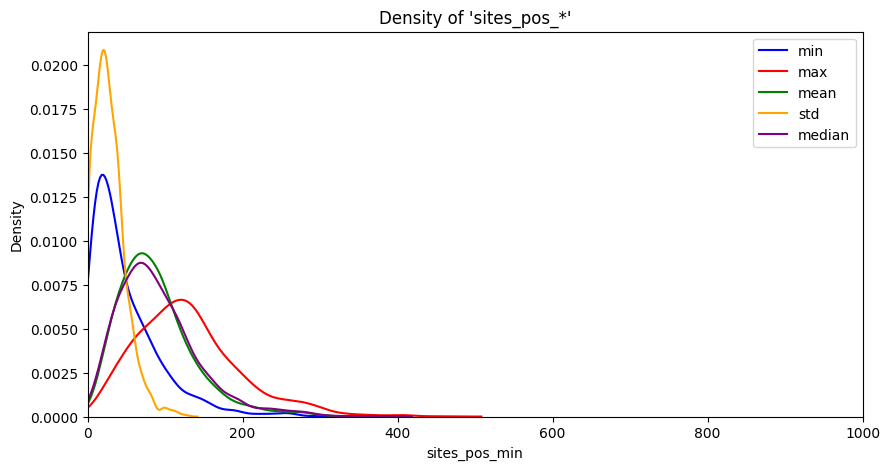

In [26]:
eda_binding_sites(df_all.query("fold != -1"))

In [28]:
# save all data with fold information (exclude -1)
df_all.query("fold != -1").to_parquet("data_preparation/all_proteins_with_fold.parquet", index=False)